In [1]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn import decomposition

from plotting import Plotting
from lasso import Lasso
from cholesky import Cholesky


In [2]:
#scoring = 'r2'
#scoring_neg = False
#scoring_label = 'R²'
#scoring_label_loss = 'R²'

scoring = 'neg_mean_squared_error'
scoring_neg = True
scoring_label = 'MSE'
scoring_label_loss = 'Squared loss'

In [3]:
column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [4]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')

In [5]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)

In [6]:
useLabelEncoder = False
useColumnCat = True

if useLabelEncoder:
    labelencoder = LabelEncoder()

    for c in categories_columns:
        c_name = c + '_cat'
        data_frame[c_name] = labelencoder.fit_transform(data_frame[c])
        numerics_columns.append(c_name)

    data_frame.drop(columns=categories_columns, inplace=True)
elif useColumnCat:
    # genera le colonne per ogni elemento di una colonna categoria
    columns_categories = pandas.DataFrame()

    for c in categories_columns:
        column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')        
        columns_categories = pandas.concat((columns_categories, column), axis=1)

    for col in columns_categories.columns: 
        numerics_columns.append(col)
        
    # elimina le colonne categoria
    data_frame.drop(columns=categories_columns, inplace=True)

    # aggiungi le colonne per ogni elemento di una colonna categoria
    data_frame = pandas.concat([data_frame, columns_categories], axis=1)
else:
    data_frame['ocean_proximity'].replace(['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'ISLAND', 'NEAR BAY'], [1, 20, 100, 1500, 500], inplace=True)
    numerics_columns.append('ocean_proximity')

In [7]:
columns_to_remove = []
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)
        
data_frame.drop(columns=columns_to_remove, inplace=True)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

In [8]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,0,1,0,0,0


In [9]:
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [10]:
useMinMaxScaler = True

if useMinMaxScaler:
    column_to_predict_idx = data_frame.columns.get_loc(column_to_predict)
    cols = list(range(0, data_frame.shape[1]))
    cols.remove(column_to_predict_idx)

    scaler = MinMaxScaler()
    scaler.fit(data_frame)
    data_frame = scaler.transform(data_frame)    
    
data_frame = pandas.DataFrame(data_frame, columns=columns_to_use)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]


In [11]:
column_to_predict_idx = data_frame.columns.get_loc(column_to_predict)
cols = list(range(0, data_frame.shape[1]))
cols.remove(column_to_predict_idx)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

In [12]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,0.0,0.0,0.0,1.0,0.0
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,0.0,0.0,0.0,1.0,0.0
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,0.0,0.0,0.0,1.0,0.0
3,0.209163,0.564293,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699,0.0,0.0,0.0,1.0,0.0
4,0.209163,0.564293,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,0.324701,0.737513,0.470588,0.042296,0.057883,0.023599,0.054103,0.073130,0.0,1.0,0.0,0.0,0.0
20636,0.312749,0.738576,0.333333,0.017676,0.023122,0.009894,0.018582,0.141853,0.0,1.0,0.0,0.0,0.0
20637,0.311753,0.732200,0.313725,0.057277,0.075109,0.028140,0.071041,0.082764,0.0,1.0,0.0,0.0,0.0
20638,0.301793,0.732200,0.333333,0.047256,0.063315,0.020684,0.057227,0.094295,0.0,1.0,0.0,0.0,0.0


In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1986)

print('Train size:', x_train.shape[0])
print('Test size:', x_test.shape[0])

Train size: 16512
Test size: 4128


In [14]:
min_ts = int(x_train.shape[0] * 0.01)
max_ts = int(x_train.shape[0] * 0.8)
step_ts = int(x_train.shape[0] * 0.1)
sizes = range(min_ts, max_ts, step_ts)

print(sizes)

range(165, 13209, 1651)


In [15]:
learner = Cholesky(1e-05)
#learner = Ridge(1e-05, fit_intercept=True, normalize=True, solver='cholesky')
#learner = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)

In [16]:
scores = cross_val_score(learner, x_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
-scores.mean()

0.020168495362565587

In [17]:
train_size, train_score, val_score = learning_curve(learner, x_train, y_train, train_sizes=sizes, cv=5, scoring=scoring, shuffle = True, random_state=1986, n_jobs=-1)

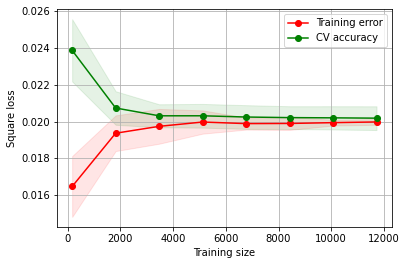

In [18]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)
plt.grid()
plt.fill_between(sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(sizes, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(sizes, train_score_mean, 'o-', color="r",
         label="Training error")
plt.plot(sizes, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Square loss')
plt.show()

In [19]:
coef_list = []

min_ts = int(X.shape[0] * 0.01)
max_ts = int(X.shape[0] * 0.8)
step_ts = int(X.shape[0] * 0.1)
sizes = range(min_ts, max_ts, step_ts)

for s in sizes:
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=s, random_state=1986)
    learner.fit(x_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

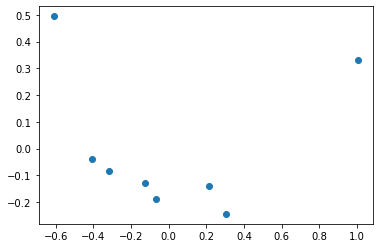

In [20]:
pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

fig, ax = plt.subplots()
#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-0.5, 0.5)
plt.scatter(coef_pca[:,0], coef_pca[:,1])

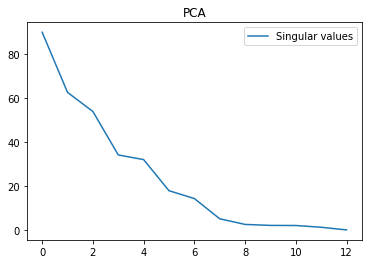

In [21]:
pca = decomposition.PCA(n_components=13)
pca.fit(X)

plt.title('PCA')
plt.plot(pca.singular_values_, label='Singular values')
plt.legend()
plt.show()

In [22]:
pca = decomposition.PCA(n_components=8)
pca.fit(X)
X_pca = pca.transform(X)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.8, shuffle=True, random_state=1986)

print('Train size:', x_train.shape[0])
print('Test size:', x_test.shape[0])

min_ts = int(x_train.shape[0] * 0.01)
max_ts = int(x_train.shape[0] * 0.8)
step_ts = int(x_train.shape[0] * 0.1)
sizes = range(min_ts, max_ts, step_ts)

print(sizes)

Train size: 16512
Test size: 4128
range(165, 13209, 1651)


In [24]:
train_size, train_score, val_score = learning_curve(learner, x_train, y_train, train_sizes=sizes, cv=5, scoring=scoring, shuffle = True, random_state=1986, n_jobs=-1)

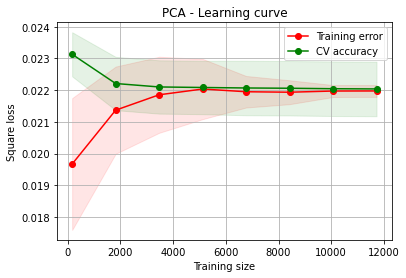

In [25]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

plt.grid()
plt.title('PCA - Learning curve')
plt.fill_between(sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(sizes, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(sizes, train_score_mean, 'o-', color="r",
         label="Training error")
plt.plot(sizes, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Square loss')
plt.show()


In [26]:
coef_list = []

for s in sizes:
    x_train, x_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, random_state=1986)
    learner.fit(x_train, y_train)
    coef_list.append(learner.coef_)
    
coef_matrix = numpy.array(coef_list)

pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

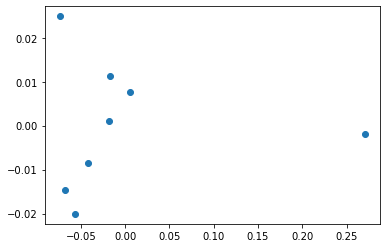

In [27]:
fig, ax = plt.subplots()
#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-0.5, 0.5)
plt.scatter(coef_pca[:,0], coef_pca[:,1])